In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, roc_curve
)

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

from imblearn.over_sampling import SMOTE

# xgboost optional
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
except:
    XGBOOST_AVAILABLE = False


In [2]:
df = pd.read_csv("C:/Users/ADITI/CreditPathAI_Oct_Batch/datasets/Loan_Default.csv")
print("Shape:", df.shape)
df.head()

Shape: (148670, 34)


,ID,year,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,...,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Region,Security_Type,Status,dtir1
0,24890,2019,cf,Sex Not Available,nopre,type1,p1,l1,nopc,nob/c,...,EXP,758,CIB,25-34,to_inst,98.728814,south,direct,1,45.0
1,24891,2019,cf,Male,nopre,type2,p1,l1,nopc,b/c,...,EQUI,552,EXP,55-64,to_inst,NaN,North,direct,1,NaN
2,24892,2019,cf,Male,pre,type1,p1,l1,nopc,nob/c,...,EXP,834,CIB,35-44,to_inst,80.019685,south,direct,0,46.0
3,24893,2019,cf,Male,nopre,type1,p4,l1,nopc,nob/c,...,EXP,587,CIB,45-54,not_inst,69.376900,North,direct,0,42.0
4,24894,2019,cf,Joint,pre,type1,p1,l1,nopc,nob/c,...,CRIF,602,EXP,25-34,not_inst,91.886544,North,direct,0,39.0


In [3]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148670 entries, 0 to 148669
Data columns (total 34 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   ID                         148670 non-null  int64  
 1   year                       148670 non-null  int64  
 2   loan_limit                 145326 non-null  object 
 3   Gender                     148670 non-null  object 
 4   approv_in_adv              147762 non-null  object 
 5   loan_type                  148670 non-null  object 
 6   loan_purpose               148536 non-null  object 
 7   Credit_Worthiness          148670 non-null  object 
 8   open_credit                148670 non-null  object 
 9   business_or_commercial     148670 non-null  object 
 10  loan_amount                148670 non-null  int64  
 11  rate_of_interest           112231 non-null  float64
 12  Interest_rate_spread       112031 non-null  float64
 13  Upfront_charges            10

,ID,year,loan_amount,rate_of_interest,Interest_rate_spread,Upfront_charges,term,property_value,income,Credit_Score,LTV,Status,dtir1
count,148670.000000,148670.0,1.486700e+05,112231.000000,112031.000000,109028.000000,148629.000000,1.335720e+05,139520.000000,148670.000000,133572.000000,148670.000000,124549.000000
mean,99224.500000,2019.0,3.311177e+05,4.045476,0.441656,3224.996127,335.136582,4.978935e+05,6957.338876,699.789103,72.746457,0.246445,37.732932
std,42917.476598,0.0,1.839093e+05,0.561391,0.513043,3251.121510,58.409084,3.599353e+05,6496.586382,115.875857,39.967603,0.430942,10.545435
min,24890.000000,2019.0,1.650000e+04,0.000000,-3.638000,0.000000,96.000000,8.000000e+03,0.000000,500.000000,0.967478,0.000000,5.000000
25%,62057.250000,2019.0,1.965000e+05,3.625000,0.076000,581.490000,360.000000,2.680000e+05,3720.000000,599.000000,60.474860,0.000000,31.000000
50%,99224.500000,2019.0,2.965000e+05,3.990000,0.390400,2596.450000,360.000000,4.180000e+05,5760.000000,699.000000,75.135870,0.000000,39.000000
75%,136391.750000,2019.0,4.365000e+05,4.375000,0.775400,4812.500000,360.000000,6.280000e+05,8520.000000,800.000000,86.184211,0.000000,45.000000
max,173559.000000,2019.0,3.576500e+06,8.000000,3.357000,60000.000000,360.000000,1.650800e+07,578580.000000,900.000000,7831.250000,1.000000,61.000000


In [4]:
# 1. Identify all categorical columns (your list)
cat_cols = [
    "loan_limit","Gender","approv_in_adv","loan_type","loan_purpose",
    "Credit_Worthiness","open_credit","business_or_commercial",
    "Neg_ammortization","interest_only","lump_sum_payment",
    "construction_type","occupancy_type","Secured_by","total_units",
    "credit_type","co-applicant_credit_type","age",
    "submission_of_application","Region","Security_Type"
]

# 2. One-hot encode them
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

print("Shape after encoding:", df.shape)

Shape after encoding: (148670, 51)


In [5]:
cols_to_drop = [
    'ID', 'loan_limit_ncf', 'approv_in_adv_pre', 
    'loan_type_type2', 'loan_type_type3',
    'loan_purpose_p2', 'loan_purpose_p3', 'loan_purpose_p4',
    'Credit_Worthiness_l2', 'open_credit_opc',
    'business_or_commercial_nob/c', 'Neg_ammortization_not_neg',
    'interest_only_not_int', 'lump_sum_payment_not_lpsm',
    'construction_type_sb', 'occupancy_type_pr', 'occupancy_type_sr',
    'Secured_by_land', 'total_units_2U', 'total_units_3U', 'total_units_4U',
    'credit_type_CRIF', 'credit_type_EQUI', 'credit_type_EXP',
    'co-applicant_credit_type_EXP',
    'age_35-44', 'age_45-54', 'age_55-64', 'age_65-74', 
    'age_<25', 'age_>74',
    'submission_of_application_to_inst',
    'Region_North-East', 'Region_central', 'Region_south',
    'Security_Type_direct'
]

df = df.drop(columns=cols_to_drop, errors="ignore")

In [6]:
num_cols = df.select_dtypes(include=['int64','float64']).columns
for col in num_cols:
    df[col] = df[col].fillna(df[col].median())

In [7]:
TARGET = "Status"
le = LabelEncoder()
df[TARGET] = le.fit_transform(df[TARGET])

In [8]:
X = df.drop(columns=[TARGET])
y = df[TARGET]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

print("Train:", X_train.shape)
print("Test :", X_test.shape)

Train: (118936, 14)
Test : (29734, 14)


In [9]:
numeric_features = X_train.select_dtypes(include=[np.number]).columns

scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test_scaled[numeric_features] = scaler.transform(X_test[numeric_features])

In [10]:
df.dtypes[df.dtypes == "object"]

Series([], dtype: object)

In [11]:
sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train_scaled, y_train)

X_train_sm = pd.DataFrame(X_train_sm, columns=X_train_scaled.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test_scaled.columns)

# Clean column names for XGBoost
def clean_cols(df):
    df.columns = (
        df.columns
        .str.replace("[","",regex=False)
        .str.replace("]","",regex=False)
        .str.replace("<","",regex=False)
        .str.replace(">","",regex=False)
        .str.replace(" ","_",regex=False)
    )
    return df

X_train_sm = clean_cols(X_train_sm)
X_test_scaled = clean_cols(X_test_scaled)

print("After SMOTE:", X_train_sm.shape)

After SMOTE: (179250, 14)


In [12]:
# STEP 5 — SMOTE ON TRAINING ONLY
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train_scaled, y_train)

print("Class balance after SMOTE:")
print(y_train_sm.value_counts())

# Convert back to DataFrame (XGBoost requirement)
X_train_sm = pd.DataFrame(X_train_sm, columns=X_train_scaled.columns)

# Clean column names (remove brackets, spaces)
X_train_sm.columns = (
    X_train_sm.columns
    .str.replace("[", "", regex=False)
    .str.replace("]", "", regex=False)
    .str.replace("<", "", regex=False)
    .str.replace(">", "", regex=False)
    .str.replace(" ", "_", regex=False)
)

# Clean test columns too
X_test_scaled.columns = (
    X_test_scaled.columns
    .str.replace("[", "", regex=False)
    .str.replace("]", "", regex=False)
    .str.replace("<", "", regex=False)
    .str.replace(">", "", regex=False)
    .str.replace(" ", "_", regex=False)
)


Class balance after SMOTE:
Status
0    89625
1    89625
Name: count, dtype: int64


In [13]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=2000, class_weight='balanced'),
    "Decision Tree": DecisionTreeClassifier(max_depth=None, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(
        n_estimators=300, max_depth=None, class_weight='balanced', random_state=42),
    "Extra Trees": ExtraTreesClassifier(n_estimators=300, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(
        learning_rate=0.05, n_estimators=300, max_depth=5, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5)
}

if XGBOOST_AVAILABLE:
    models["XGBoost"] = xgb.XGBClassifier(
        eval_metric='logloss', learning_rate=0.05,
        n_estimators=400, max_depth=8, subsample=0.8,
        colsample_bytree=0.8, random_state=42
    )

trained_models = {}

for name, model in models.items():
    print(f"\nTraining {name} ...")
    model.fit(X_train_sm, y_train_sm)
    trained_models[name] = model
    print(f"{name} trained.")


Training Logistic Regression ...
Logistic Regression trained.

Training Decision Tree ...
Decision Tree trained.

Training Random Forest ...
Random Forest trained.

Training Extra Trees ...
Extra Trees trained.

Training Gradient Boosting ...
Gradient Boosting trained.

Training KNN ...
KNN trained.

Training XGBoost ...
XGBoost trained.


In [14]:
# Model Performance
print("\n\n==================== MODEL PERFORMANCE ====================\n")

for name, model in trained_models.items():

    # Predictions
    y_pred = model.predict(X_test_scaled)

    # Probabilities (if available)
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test_scaled)[:, 1]
    else:
        y_proba = None

    
    # Train Metrics
    y_train_pred = model.predict(X_train_sm)
    train_acc = accuracy_score(y_train_sm, y_train_pred)

    # Test Metrics
    test_acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None

    # PRINT FORMATTED OUTPUT
    print(f"===== {name} =====")
    print(f"Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    if auc is not None:
        print(f"ROC-AUC:   {auc:.4f}")
    else:
        print("ROC-AUC:   Not Available")



==================== MODEL PERFORMANCE ====================

===== Logistic Regression =====
Train Accuracy: 0.6252, Test Accuracy: 0.5919
Precision: 0.3385
Recall:    0.6874
F1 Score:  0.4536
ROC-AUC:   0.6356
===== Decision Tree =====
Train Accuracy: 1.0000, Test Accuracy: 0.9999
Precision: 1.0000
Recall:    0.9995
F1 Score:  0.9997
ROC-AUC:   0.9997
===== Random Forest =====
Train Accuracy: 1.0000, Test Accuracy: 1.0000
Precision: 1.0000
Recall:    1.0000
F1 Score:  1.0000
ROC-AUC:   1.0000
===== Extra Trees =====
Train Accuracy: 1.0000, Test Accuracy: 0.9988
Precision: 0.9971
Recall:    0.9981
F1 Score:  0.9976
ROC-AUC:   1.0000
===== Gradient Boosting =====
Train Accuracy: 1.0000, Test Accuracy: 0.9999
Precision: 1.0000
Recall:    0.9997
F1 Score:  0.9999
ROC-AUC:   1.0000
===== KNN =====
Train Accuracy: 0.9738, Test Accuracy: 0.9480
Precision: 0.8298
Recall:    0.9928
F1 Score:  0.9040
ROC-AUC:   0.9836
===== XGBoost =====
Train Accuracy: 1.0000, Test Accuracy: 1.0000
Precision



==================== CONFUSION MATRICES ====================


===== Logistic Regression =====
[[12563  9843]
 [ 2291  5037]]


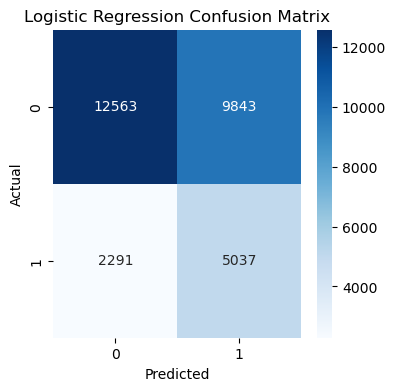


===== Decision Tree =====
[[22406     0]
 [    4  7324]]


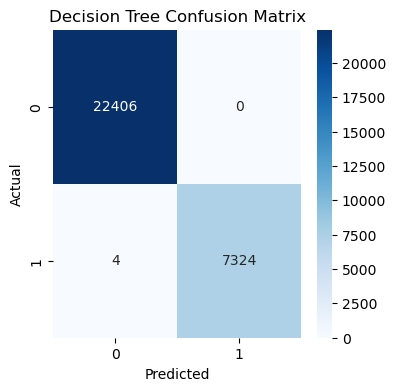


===== Random Forest =====
[[22406     0]
 [    0  7328]]


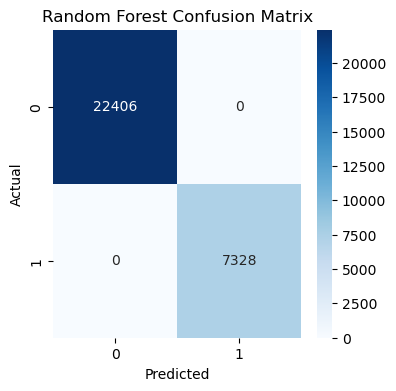


===== Extra Trees =====
[[22385    21]
 [   14  7314]]


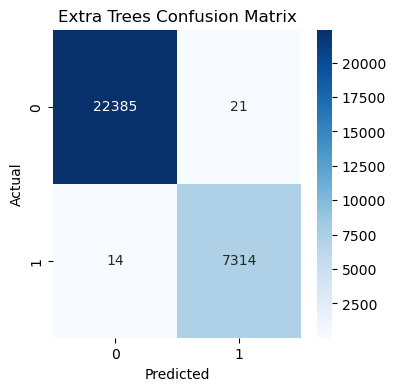


===== Gradient Boosting =====
[[22406     0]
 [    2  7326]]


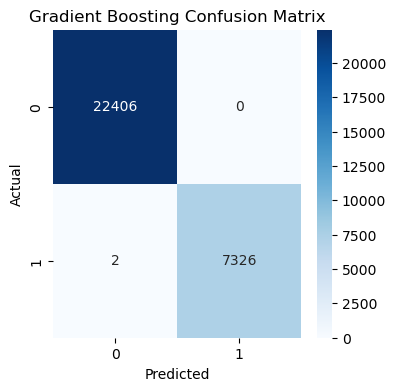


===== KNN =====
[[20914  1492]
 [   53  7275]]


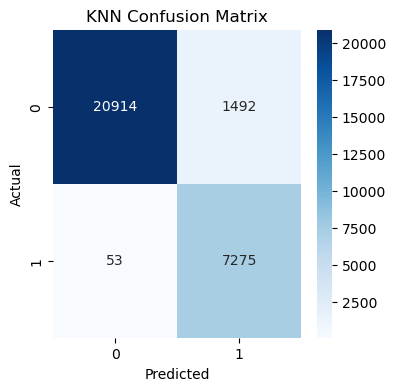


===== XGBoost =====
[[22406     0]
 [    0  7328]]


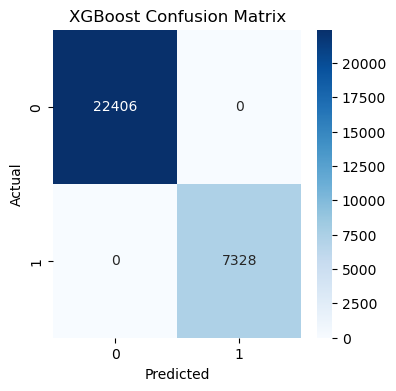

In [15]:
# Confusion Matrix
print("\n\n==================== CONFUSION MATRICES ====================\n")

for name, model in trained_models.items():
    y_pred = model.predict(X_test_scaled)
    cm = confusion_matrix(y_test, y_pred)

    print(f"\n===== {name} =====")
    print(cm)

    plt.figure(figsize=(4,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

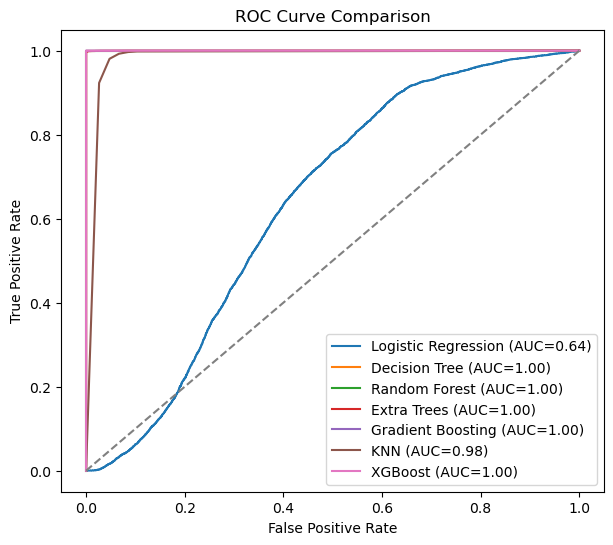

In [18]:
# ROC Curve
plt.figure(figsize=(7,6))

for name, model in trained_models.items():
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test_scaled)[:,1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        auc = roc_auc_score(y_test, y_proba)
        plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.2f})")

plt.plot([0,1],[0,1],'--',color='gray')
plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

In [17]:
# ====================== FINAL METRICS TABLE ==========================
results = []

for name, model in trained_models.items():

    # ---- TRAIN ----
    y_train_pred = model.predict(X_train_sm)

    if hasattr(model, "predict_proba"):
        y_train_proba = model.predict_proba(X_train_sm)[:, 1]
    else:
        y_train_proba = None

    train_acc = accuracy_score(y_train_sm, y_train_pred)
    train_prec = precision_score(y_train_sm, y_train_pred)
    train_rec = recall_score(y_train_sm, y_train_pred)
    train_f1 = f1_score(y_train_sm, y_train_pred)
    train_auc = roc_auc_score(y_train_sm, y_train_proba) if y_train_proba is not None else None

    # ---- TEST ----
    y_test_pred = model.predict(X_test_scaled)

    if hasattr(model, "predict_proba"):
        y_test_proba = model.predict_proba(X_test_scaled)[:, 1]
    else:
        y_test_proba = None

    test_acc = accuracy_score(y_test, y_test_pred)
    test_prec = precision_score(y_test, y_test_pred)
    test_rec = recall_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred)
    test_auc = roc_auc_score(y_test, y_test_proba) if y_test_proba is not None else None

    # Append results
    results.append([
        name,
        train_acc, train_prec, train_rec, train_f1, train_auc,
        test_acc, test_prec, test_rec, test_f1, test_auc
    ])

# Create DataFrame
columns = [
    "Model",
    "Train Accuracy", "Train Precision", "Train Recall", "Train F1", "Train ROC-AUC",
    "Test Accuracy", "Test Precision", "Test Recall", "Test F1", "Test ROC-AUC"
]

results_df = pd.DataFrame(results, columns=columns)

print("\n==================== FINAL MODEL PERFORMANCE TABLE ====================\n")
display(results_df)



==================== FINAL MODEL PERFORMANCE TABLE ====================



,Model,Train Accuracy,Train Precision,Train Recall,Train F1,Train ROC-AUC,Test Accuracy,Test Precision,Test Recall,Test F1,Test ROC-AUC
0,Logistic Regression,0.625194,0.610911,0.689584,0.647868,0.637895,0.591915,0.338508,0.687364,0.453620,0.635617
1,Decision Tree,1.000000,1.000000,1.000000,1.000000,1.000000,0.999865,1.000000,0.999454,0.999727,0.999727
2,Random Forest,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
3,Extra Trees,1.000000,1.000000,1.000000,1.000000,1.000000,0.998823,0.997137,0.998090,0.997613,0.999969
4,Gradient Boosting,1.000000,1.000000,1.000000,1.000000,1.000000,0.999933,1.000000,0.999727,0.999864,1.000000
5,KNN,0.973808,0.950624,0.999531,0.974464,0.999664,0.948039,0.829816,0.992767,0.904007,0.983573
6,XGBoost,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
